### Import Library

In [1]:
%pylab inline

import os
import numpy as np
from PIL import Image

from os import listdir
from PIL import Image

from skimage.io import imread
from skimage.transform import resize 

from os.path import isfile, isdir

from convlstm2d import ConvLSTMCell
from torch.autograd import Variable
import torch
from torch.nn import Conv2d, ConvTranspose2d
from torch.nn.modules import UpsamplingNearest2d, Conv2d, Upsample, Sequential
import torch.nn.functional as F

Populating the interactive namespace from numpy and matplotlib


### Get Clean And Croped Data And Save Data

In [86]:
def get_clean_data(path = 'data'):
    data_dir = os.path.join(os.getcwd(), path)
    image_files = [os.path.join(data_dir, f) for f in listdir(data_dir) if isfile(os.path.join(data_dir, f))]
    
    def get_image_id(path):
        names = []
        for i, name in enumerate(path):
            image_id = name[name.find('data')+5:name.find('.')]
            names.append(image_id)
        return names
    
    def get_info_from_image(index):
        image_path = image_files[index]
        image_obj = Image.open(image_path)
        coords = (480, 14, 580, 27)
        corped_image = image_obj.crop(coords)
        return np.array(corped_image)
    
    image_ids = get_image_id(image_files)
    croped_image = get_info_from_image(2)
    
    invalid_image_paths = []
    
    for i, image_path in enumerate(image_files):
        
        try:
            IMG = Image.open(image_path)
            img = get_info_from_image(i)
            if np.min(croped_image == img) == True:
                coord = (0, 0, 480, 480)
                cropped_image = IMG.crop(coord)
                dirs = os.path.join(os.getcwd(), 'New Data',image_ids[i] + '.gif')
                cropped_image.save(dirs)
        except:
            invalid_image_paths.append(image_files)
    
    return print('We have {} Invalid Images found from the dataset.'.format(len(invalid_image_paths)))

In [87]:
get_clean_data()

We have 0 Invalid Images found from the dataset.


### Set Data To Workable Form 

In [7]:
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'Clean data')

c = [os.path.join(data_dir, f) for f in listdir(data_dir) if isfile(os.path.join(data_dir, f))]
image_names = [f for f in listdir(data_dir) if isfile(os.path.join(data_dir, f))]


In [12]:
IMAGES_WIDTH = 256
IMAGES_HEIGHT = 256
IMAGES_DEPTH = 3

np.random.seed(14)
image_path = c[0]

In [51]:
features_list = np.zeros((1, IMAGES_WIDTH, IMAGES_HEIGHT, IMAGES_DEPTH), dtype = np.uint8)

def get_feature_images(paths, features_list):
    for i, path in enumerate(paths):
        image = imread(path)[:, :, :IMAGES_DEPTH]
        image = resize(image, (IMAGES_WIDTH, IMAGES_HEIGHT), mode='constant', preserve_range=True)
        features_list[i] = image
    return features_list

    
sys.stdout.flush()
    
print('Getting Training Data...')

X_train = get_feature_images(image, features_list)

print('Training data loading completed!')


print('we have {} Training Images Found.'.format(len(X_train)))

print('All data completely loaded!')

Getting Training Data...


AttributeError: 'numpy.ndarray' object has no attribute 'read'

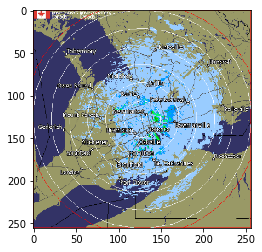

In [83]:
def get_image(image_path):
    features_list = np.zeros((IMAGES_WIDTH, IMAGES_HEIGHT, IMAGES_DEPTH), dtype = np.uint8)
    image = imread(image_path)[:, :, :3]
    image = resize(image, (IMAGES_WIDTH, IMAGES_HEIGHT), mode='constant', preserve_range=True)
    features_list= image.astype(int)
    return features_list

### Normalize data

In [ ]:
def normalize(x):
    samples = []
    for sample in x:
        samples.append(sample / 255)
    return np.array(samples)

X_train = normalize(X_train)

### Display Image Data From Random Index

In [16]:
def display_images(id_, X_train):
    plt.imshow(X_train[id_])
    plt.show()

id_ = np.random.randint(len(X_train))
display_images(id_, np.squeeze(X_train))

NameError: name 'X_train' is not defined

### Define Model Here

In [ ]:
display_images(ima)

In [ ]:
input = Variable(torch.rand( 6, 3, 256, 256))
decoder_input = Variable(torch.rand( 6, 80, 8, 8))

In [ ]:
conv = Conv2d(3, 16, kernel_size=(3, 3), stride=2, padding=1)(input)

conv1 = Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=1)(F.relu(conv))
conv2 = Conv2d(32, 48, kernel_size=(3, 3), stride=2, padding=1)(F.relu(conv1))

conv3 = Conv2d(48, 64, kernel_size=(3, 3), stride=2, padding=1)(F.relu(conv2))
conv4 = Conv2d(64, 80, kernel_size=(3, 3), stride=2, padding=1)(F.relu(conv3))

Encoder, prev_c,= ConvLSTMCell(80, 80)(F.relu(conv4), None)
states = (Encoder, prev_c)

decoder_cell = ConvLSTMCell(80, 80)

decoder, _ = decoder_cell(decoder_input, states)

layer = ConvTranspose2d(80, 80, kernel_size=(1, 1))(F.relu(decoder))
m = torch.cat([F.relu(layer), conv4], dim=1)

layer1 = ConvTranspose2d(160, 64, kernel_size=(2, 2), stride=2)(m)
m1 = torch.cat([F.relu(layer1), conv3], dim=1)

layer2 = ConvTranspose2d(128, 48, kernel_size=(2, 2), stride=2)(m1)
m2 = torch.cat([F.relu(layer2), conv2], dim=1)

layer3 = ConvTranspose2d(96, 32, kernel_size=(2, 2), stride=2)(m2)
m3 = torch.cat([F.relu(layer3), conv1], dim=1)

layer4 = ConvTranspose2d(64, 16, kernel_size=(2, 2), stride=2)(m3)
m4 = torch.cat([F.relu(layer4), conv], dim=1)

output = ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=2)(m4)